In [ ]:
# train a model that serves as our ground truth
# for static scenes use splatfacto? probably better to use original 3dgs method so render function is the same
# for dynamic scenes use any one of the 3dgs methods 

# render the images using custom viewpoints derived from the original viewpoint
# vary the distance between the original training data and the object - can do this by maybe calculating the center of gravity of the object and a vector between that and the camera location. move translation along this vector?
# is there a smarter way to more realistically simulate the level of multiplexing?

# for dynamics, render lightfield views for each timestep
# we are just comparing monocular video, still video?
# we could also do multiview with 3 views...is there a 360 degree dataset
# i guess we could just do our own rendering by training with our own custom dataset?
# is it worth figuring out how to get the 3d model so we can render it for real with as much detail as possible (probably not)

# from the train transforms.json read in the transforms and then generate new camera views
# do i need to change the rotation if i translate the object along the vector? could change the rotation so that the camera is facing the object center of gravity. i wonder how much it’s deviating right now

# instead of translating the object along the vector to cog i should just translate it along the primary view direction (which i should be able to get from the extrinsics)
# maybe that’s a good way to generate unseen views anyway

In [ ]:
# change working directory if necessary
import copy
import os
import sys
from argparse import ArgumentParser
from typing import List

os.chdir('/home/wl757/gaussian-splatting')
print(os.getcwd())

import matplotlib.pyplot as plt
import numpy as np
import torch
from arguments import ModelParams, PipelineParams
from argparse import Namespace
from gaussian_renderer import render
from scene.gaussian_model import GaussianModel
from scene import Scene
from scene.cameras import Camera
from utils.general_utils import safe_state
from utils.graphics_utils import getWorld2View2
from utils.image_utils import psnr

def get_combined_args(parser: ArgumentParser, cmdlne_string = List[str]):
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)

    try:
        cfgfilepath = os.path.join(args_cmdline.model_path, "cfg_args")
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file not found at")
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    print(merged_dict)
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v
    return Namespace(**merged_dict)

parser = ArgumentParser()
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument("--quiet", action="store_true", help="Suppress output messages")
args = get_combined_args(parser, ["--model_path", "/home/wl757/gaussian-splatting/output/lego"])
print("Rendering " + args.model_path)

# Initialize system state (RNG)
safe_state(args.quiet)
dataset = model.extract(args)
iteration = args.iteration
pp = pipeline.extract(args)

with torch.no_grad():
    gaussians = GaussianModel(dataset.sh_degree)
    scene = Scene(dataset, gaussians, load_iteration=iteration, shuffle=False)

/home/wl757/gaussian-splatting
Looking for config file in /home/wl757/gaussian-splatting/output/lego/cfg_args
Config file found: /home/wl757/gaussian-splatting/output/lego/cfg_args
{'data_device': 'cuda', 'depths': '', 'eval': False, 'images': 'images', 'model_path': 'output/lego_black', 'resolution': -1, 'sh_degree': 3, 'source_path': '/home/wl757/multiplexed-pixels/plenoxels/nerf_synthetic/lego', 'train_test_exp': False, 'white_background': False}
Rendering /home/wl757/gaussian-splatting/output/lego
Loading trained model at iteration 30000 [13/07 22:19:14]
Found transforms_train.json file, assuming Blender data set! [13/07 22:19:14]
Reading Training Transforms [13/07 22:19:14]
Reading Test Transforms [13/07 22:19:19]
Loading Training Cameras [13/07 22:19:29]
Loading Test Cameras [13/07 22:19:36]


['/jupyter-js-widgets/extension.js', '/open3d/extension.js'] [13/07 22:19:36]
PSNR:  36.278236389160156 [13/07 22:19:36]
cog: [0.0323316864669323, -0.056738946586847305, 0.19368238747119904] [13/07 22:19:37]
Distance from camera to object center of gravity: 4.0328 [13/07 22:19:37]
cog: [0.0323316864669323, -0.056738946586847305, 0.19368238747119904] [13/07 22:19:37]
New distance from camera to object center of gravity: 6.0311 [13/07 22:19:37]


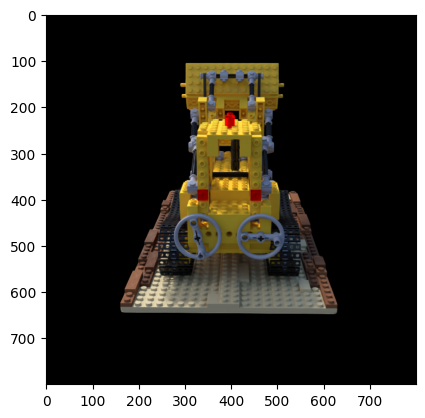

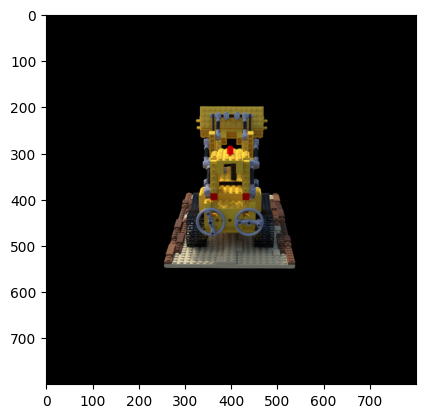

In [2]:
@torch.no_grad()
def center_of_gravity(gaussians: GaussianModel):
    return gaussians.get_xyz.mean(dim=0)

def camera_forward(camera: Camera):
    R = camera.R
    if not torch.is_tensor(R):
        R = torch.tensor(R, dtype=torch.float32, device=camera.data_device)
    
    z_axis_cam = torch.tensor([0, 0, 1], dtype=torch.float32, device=camera.data_device)
    forward = torch.mv(R, z_axis_cam)
    forward = forward / torch.norm(forward)
    return forward

@torch.no_grad()
def camera_to_object(camera: Camera, gaussians: GaussianModel):
    cog = center_of_gravity(gaussians)
    print(f"cog: {cog.tolist()}")
    camera_position = camera.camera_center.to(cog.device)
    camera_to_object_vector = cog - camera_position
    distance = torch.norm(camera_to_object_vector)
    vector = camera_to_object_vector / distance

    return distance.item(), vector

def translate_camera(original_camera: Camera, delta: List[float]):
    new_camera: Camera = copy.deepcopy(original_camera)
    delta = np.array(delta, dtype=np.float32)

    # calculate new T (don't use camera.trans as it is not supported in other code)
    new_world_center = new_camera.camera_center.cpu().numpy() + delta
    new_camera_center = new_world_center / new_camera.scale - new_camera.trans
    new_camera.T = -np.matmul(new_camera.R.T, new_camera_center)

    new_camera.world_view_transform = torch.tensor(getWorld2View2(new_camera.R, new_camera.T, new_camera.trans, new_camera.scale), 
                                                   device=new_camera.data_device, dtype=torch.float32).transpose(0, 1)
    new_camera.full_proj_transform = (new_camera.world_view_transform.unsqueeze(0).bmm(new_camera.projection_matrix.unsqueeze(0))).squeeze(0)
    new_camera.camera_center = new_camera.world_view_transform.inverse()[3, :3]
    
    for p in new_camera.parameters(): p.requires_grad_(False)
    return new_camera

def render_sets(dataset : ModelParams, iteration : int, pipeline : PipelineParams, scene, gaussians):
    with torch.no_grad():
        dataset.white_background = False
        bg_color = [1,1,1] if dataset.white_background else [0, 0, 0]
        background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

        camera = scene.getTrainCameras()[0]
        rendering = render(camera, gaussians, pipeline, background)["render"]
        gt = camera.original_image[0:3, :, :]
        print("PSNR: ", psnr(rendering, gt).mean().item())
        plt.imshow(rendering.permute(1, 2, 0).cpu().numpy())
        plt.show()

        distance, vector = camera_to_object(camera, gaussians)
        forward_vector = camera_forward(camera)
        dot = torch.clamp(torch.dot(forward_vector, vector), -1.0, 1.0)
        angle_rad = torch.acos(dot)
        import math
        # angle_deg = angle_rad * 180.0 / math.pi
        # print(f"Angle between camera forward vector and object center of gravity vector: {angle_deg:.2f} degrees")

        # print(f"Vector from camera to object center of gravity: {vector.tolist()}")
        # print(f"Forward vector of camera: {forward_vector.tolist()}")
        # print(f"Camera position: {camera.camera_center.tolist()}")
        print(f"Distance from camera to object center of gravity: {distance:.4f}")
        step = -2
        delta = ((forward_vector) * step).tolist()
        new_camera = translate_camera(camera, delta=delta)
        distance, vector = camera_to_object(new_camera, gaussians)
        print(f"New distance from camera to object center of gravity: {distance:.4f}")
        # print(f"New camera position: {new_camera.camera_center.tolist()}")
        translated_rendering = render(new_camera, gaussians, pipeline, background)["render"]
        plt.imshow(translated_rendering.permute(1, 2, 0).cpu().numpy())
        plt.show()

render_sets(dataset, iteration, pp, scene, gaussians)

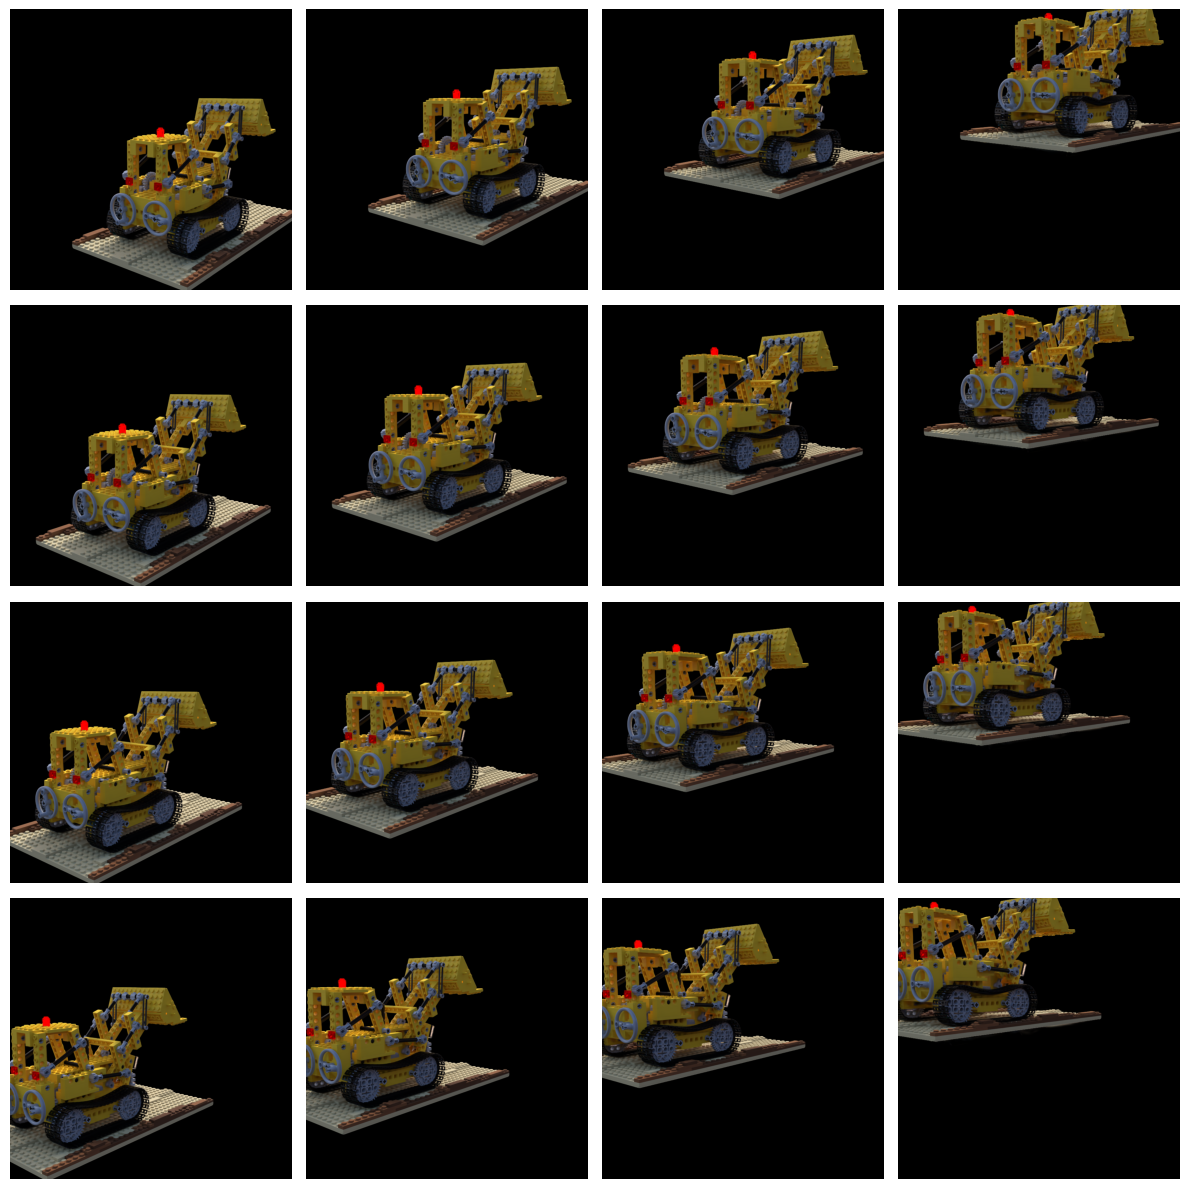

In [4]:
import json
import numpy as np
import copy
import os
from pathlib import Path
import imageio.v3 as iio
from scene.dataset_readers import CameraInfo
from utils.graphics_utils import getWorld2View2, focal2fov, fov2focal
from utils.camera_utils import camera_to_JSON, loadCam
import matplotlib.pyplot as plt
from PIL import Image

data_root = '/home/wl757/multiplexed-pixels/plenoxels/blender_data/lego_gen12'

with open(os.path.join(data_root, 'transforms_test.json'), 'r') as file:
    data = json.load(file)

# choose one image to generate new views from
indices = [111]
# indices = [0]

# 4x4 grid of new views
x_linspace = np.linspace(start = -0.5, stop = 0.5, num = 4)
data_gen = copy.deepcopy(data)

save_path = os.path.join(data_root, 'visualization_111')
os.makedirs(save_path, exist_ok=True)
frames = []

to8b = lambda x: (255 * torch.permute(x, (1, 2, 0)).clamp(0, 1).detach().cpu().numpy()).astype("uint8")

i = 0
for index in indices:
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))    
    axes = axes.flatten()
    frame = copy.deepcopy(data['frames'][index])
    c2w = np.array(frame['transform_matrix']) # NeRF 'transform_matrix' is a camera-to-world transform
    c2w[:3, 1:3] *= -1 # change from OpenGL/Blender camera axes (Y up, Z back) to COLMAP (Y down, Z forward)
    w2c = np.linalg.inv(c2w) # get the world-to-camera transform and set R, T
    R = np.transpose(w2c[:3, :3]) # R is stored transposed due to 'glm' in CUDA code
    T = w2c[:3, 3]
    cam_name = os.path.join(data_root, frame['file_path'] + ".png")
    c2w = np.linalg.inv(getWorld2View2(R, T))
    for x in x_linspace:
        for y in x_linspace:
            new_c2w = c2w.copy()
            camera_offset = np.array([x, y, 0])
            world_offset = new_c2w[:3, :3] @ camera_offset
            new_c2w[:3, 3] += world_offset
            
            new_w2c = np.linalg.inv(new_c2w)
            new_R = np.transpose(new_w2c[:3, :3])
            new_T = new_w2c[:3, 3]
            image_path = os.path.join(data_root, cam_name)
            image_name = Path(cam_name).stem
            image = Image.open(image_path)
            width, height = image.size
            fovx = data['camera_angle_x']
            fovy = focal2fov(fov2focal(fovx, height), width)

            camera = Camera(image.size, colmap_id=index, R=new_R, T=new_T, FoVx=fovx, FoVy=fovy,
                            depth_params=None, image=image, invdepthmap=None, image_name=image_name, uid=i)
            background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
            rendering = render(camera, gaussians, pp, background)["render"]
            axes[i].imshow(rendering.permute(1, 2, 0).detach().cpu().numpy())
            iio.imwrite(os.path.join(save_path, f'r_{index}_{i}.png'), to8b(rendering))
            axes[i].axis('off')
            i += 1
            frames.append(frame)
    plt.tight_layout()
    plt.show()
    i = 0


data_gen['frames'] = frames
with open(os.path.join(data_root, 'visualization_111.json'), 'w') as f:
    json.dump(data_gen, f, indent=4)


In [ ]:
import json
import numpy as np
import copy
import os
from pathlib import Path
import imageio.v3 as iio
from scene.dataset_readers import CameraInfo
from utils.graphics_utils import getWorld2View2, focal2fov, fov2focal
from utils.camera_utils import camera_to_JSON, loadCam
import matplotlib.pyplot as plt
from PIL import Image

data_root = '/home/wl757/multiplexed-pixels/plenoxels/blender_data/lego_gen12'

with open(os.path.join(data_root, 'transforms_train_gaussian_splatting_multiviews.json'), 'r') as file:
    data = json.load(file)

# choose one image to generate new views from
indices = [59]

# 4x4 grid of new views
num_views = 16
to8b = lambda x: (255 * torch.permute(x, (1, 2, 0)).clamp(0, 1).detach().cpu().numpy()).astype("uint8")
frames = {Path(frame["file_path"]).stem: frame for frame in data['frames']}

i = 0
for index in indices:
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))    
    axes = axes.flatten()
    for view_id in range(num_views):
        frame = frames[f'r_{index}_{view_id}']
        cam_name = os.path.join(data_root, frame['file_path'] + ".png")
        c2w = np.array(frame['transform_matrix'])
        c2w[:3, 1:3] *= -1
        w2c = np.linalg.inv(c2w)
        R = np.transpose(w2c[:3, :3])
        T = w2c[:3, 3]
        image_path = os.path.join(data_root, cam_name)
        image_name = Path(cam_name).stem
        image = Image.open(image_path)
        width, height = image.size
        fovx = data['camera_angle_x']
        fovy = focal2fov(fov2focal(fovx, height), width)

        camera = Camera(image.size, colmap_id=index, R=R, T=T, FoVx=fovx, FoVy=fovy,
                        depth_params=None, image=image, invdepthmap=None, image_name=image_name, uid=i)
        background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
        rendering = render(camera, gaussians, pp, background)["render"]
        axes[i].imshow(rendering.permute(1, 2, 0).detach().cpu().numpy())
        axes[i].axis('off')
        i += 1
    plt.tight_layout()
    plt.show()
    i = 0

In [ ]:
import json
import numpy as np
import copy
import os
from pathlib import Path
import imageio.v3 as iio
from scene.dataset_readers import CameraInfo
from utils.graphics_utils import getWorld2View2, focal2fov, fov2focal
from utils.camera_utils import camera_to_JSON, loadCam
import matplotlib.pyplot as plt
from PIL import Image

data_root = '/home/wl757/multiplexed-pixels/plenoxels/blender_data/lego_gen12'

with open(os.path.join(data_root, 'transforms_train.json'), 'r') as file:
    data = json.load(file)

# choose one image to generate new views from
indices = [0, 50, 59]

# 4x4 grid of new views
x_linspace = np.linspace(start = -0.5, stop = 0.5, num = 4)
data_gen = copy.deepcopy(data)

# old code with incorrect multiplexing
i = 0
for index in indices:
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))    
    axes = axes.flatten()
    for x in x_linspace:
        for y in x_linspace:
            frame = copy.deepcopy(data['frames'][index])
            cam_name = os.path.join(data_root, frame['file_path'] + ".png")
            c2w = np.array(frame['transform_matrix'])
            c2w[0, -1] += x
            c2w[1, -1] += y
            c2w[:3, 1:3] *= -1
            w2c = np.linalg.inv(c2w)
            R = np.transpose(w2c[:3, :3])
            T = w2c[:3, 3]
            image_path = os.path.join(data_root, cam_name)
            image_name = Path(cam_name).stem
            image = Image.open(image_path)
            width, height = image.size
            fovx = data['camera_angle_x']
            fovy = focal2fov(fov2focal(fovx, height), width)

            camera = Camera(image.size, colmap_id=index, R=R, T=T, FoVx=fovx, FoVy=fovy,
                            depth_params=None, image=image, invdepthmap=None, image_name=image_name, uid=i)
            background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
            rendering = render(camera, gaussians, pp, background)["render"]

            axes[i].imshow(rendering.permute(1, 2, 0).detach().cpu().numpy())

            axes[i].axis('off')
            i += 1
    i = 0
    plt.tight_layout()
    plt.show()


#     frames = []
#     cnt = 0
#     for i in x_linspace:
#         for j in x_linspace:
#             sample = copy.deepcopy(view_sample)
#             sample['file_path'] = f'./render_5_views/r_{index}_{cnt}'
#             cnt += 1
#             sample['transform_matrix'][0][-1] += i
#             sample['transform_matrix'][1][-1] += j
# #             print(i,j, sample['transform_matrix'][0][-1],sample['transform_matrix'][1][-1] )
#             frames.append(sample)

#     data_gen['frames'] = frames
#     # json.dumps(frames)
#     file.close()

    # with open(f'/home/wl757/multiplexed-pixels/plenoxels/blender_data/hotdog/transforms_train_gaussian_splatting.json','w') as f:
    #     json.dump(data_gen, f)
